In [1]:
%matplotlib inline

# Example plot for LFPy: Single-synapse contribution to the LFP

Copyright (C) 2017 Computational Neuroscience Group, NMBU.

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

In [2]:
import LFPy
import numpy as np
import os
import sys
if sys.version < '3':
    from urllib2 import urlopen
else:    
    from urllib.request import urlopen
import ssl
import zipfile
import matplotlib.pyplot as plt
from matplotlib.collections import PolyCollection
from os.path import join

## Fetch Mainen&Sejnowski 1996 model files:

In [3]:
if not os.path.isfile(join('cells', 'cells', 'j4a.hoc')):
    #get the model files:
    u = urlopen('http://senselab.med.yale.edu/ModelDB/eavBinDown.asp?o=2488&a=23&mime=application/zip',
                context=ssl._create_unverified_context())
    localFile = open('patdemo.zip', 'wb')
    localFile.write(u.read())
    localFile.close()
    #unzip:
    myzip = zipfile.ZipFile('patdemo.zip', 'r')
    myzip.extractall('.')
    myzip.close()

## Main script, set parameters and create cell, synapse and electrode objects:

In [4]:
# Define cell parameters
cell_parameters = {
    'morphology' : join('cells', 'cells', 'j4a.hoc'), # from Mainen & Sejnowski, J Comput Neurosci, 1996
    'cm' : 1.0,         # membrane capacitance
    'Ra' : 150.,        # axial resistance
    'v_init' : -65.,    # initial crossmembrane potential
    'passive' : True,   # turn on NEURONs passive mechanism for all sections
    'passive_parameters' : {'g_pas' : 1./30000, 'e_pas' : -65},
    'nsegs_method' : 'lambda_f', # spatial discretization method
    'lambda_f' : 100.,           # frequency where length constants are computed
    'dt' : 2.**-3,      # simulation time step size
    'tstart' : 0.,      # start time of simulation, recorders start at t=0
    'tstop' : 100.,     # stop simulation at 100 ms.
}

# Create cell
cell = LFPy.Cell(**cell_parameters)
# Align cell
cell.set_rotation(x=4.99, y=-4.33, z=3.14)

# Define synapse parameters
synapse_parameters = {
    'idx' : cell.get_closest_idx(x=-200., y=0., z=800.),
    'e' : 0.,                   # reversal potential
    'syntype' : 'ExpSyn',       # synapse type
    'tau' : 5.,                 # synaptic time constant
    'weight' : .001,            # synaptic weight
    'record_current' : True,    # record synapse current
}

# Create synapse and set time of synaptic input
synapse = LFPy.Synapse(cell, **synapse_parameters)
synapse.set_spike_times(np.array([20.]))

# Create a grid of measurement locations, in (mum)
X, Z = np.mgrid[-700:701:50, -400:1201:50]
Y = np.zeros(X.shape)

# Define electrode parameters
grid_electrode_parameters = {
    'sigma' : 0.3,      # extracellular conductivity
    'x' : X.flatten(),  # electrode requires 1d vector of positions
    'y' : Y.flatten(),
    'z' : Z.flatten()
}

# Define electrode parameters
point_electrode_parameters = {
    'sigma' : 0.3,  # extracellular conductivity
    'x' : np.array([-130., -220.]),
    'y' : np.array([   0.,    0.]),
    'z' : np.array([   0.,  700.]),
}

# Run simulation, electrode object argument in cell.simulate
cell.simulate(rec_imem=True)

# Create electrode objects
grid_electrode = LFPy.RecExtElectrode(cell,**grid_electrode_parameters)
point_electrode = LFPy.RecExtElectrode(cell,**point_electrode_parameters)

# Calculate LFPs
grid_electrode.calc_lfp()
point_electrode.calc_lfp()

## Plot simulation output:

[]

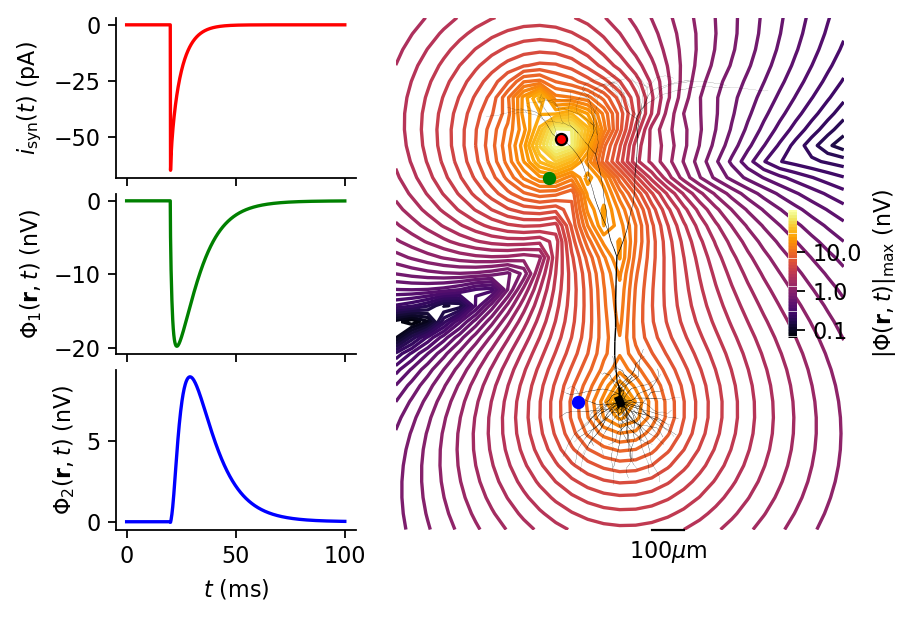

In [5]:
fig = plt.figure(dpi=160)

ax = fig.add_axes([.4,.1,.55,.8], aspect='equal', frameon=True)
cax = fig.add_axes([0.85, 0.4, 0.01, 0.2], frameon=True)

LFP = np.max(np.abs(grid_electrode.LFP),1).reshape(X.shape)
im = ax.contour(X, Z, np.log10(LFP), 
            50,
           cmap='inferno',
           zorder=-2)
cbar = fig.colorbar(im, cax=cax)
cbar.set_label('$|\Phi(\mathbf{r}, t)|_\mathrm{max}$ (nV)')
cbar.outline.set_visible(False)
#get some log-linear tickmarks and ticklabels
ticks = np.arange(np.ceil(np.log10(LFP.min())), np.floor(np.log10(LFP.max())))
cbar.set_ticks(ticks)
cbar.set_ticklabels(np.round(10.**ticks * 1E6, decimals=1)) #mV -> nV

#plot morphology
zips = []
for x, z in cell.get_idx_polygons():
    zips.append(list(zip(x, z)))
polycol = PolyCollection(zips,
                         edgecolors='none',
                         facecolors='k')
ax.add_collection(polycol)

ax.plot([100, 200], [-400, -400], 'k', lw=1, clip_on=False)
ax.text(150, -470, r'100$\mu$m', va='center', ha='center')

ax.axis('off')


ax.plot(cell.xmid[cell.synidx],cell.zmid[cell.synidx], 'o', ms=5,
        markeredgecolor='k',
        markerfacecolor='r')

color_vec = ['blue','green']
for i in range(2):
    ax.plot(point_electrode_parameters['x'][i],
                    point_electrode_parameters['z'][i],'o',ms=6,
                    markeredgecolor='none',
                    markerfacecolor=color_vec[i])

plt.axes([.15,.10,.25,.25])
plt.plot(cell.tvec,point_electrode.LFP[0]*1e6,color=color_vec[0], clip_on=False)
plt.ylabel(r'$\Phi_2(\mathbf{r},t)$ (nV)')
plt.xlabel(r'$t$ (ms)')
plt.axis('tight')
ax = plt.gca()
for loc, spine in ax.spines.items():
    if loc in ['right', 'top']:
        spine.set_color('none')            
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')


plt.axes([.15,.375,.25,.25])
plt.plot(cell.tvec,point_electrode.LFP[1]*1e6,color=color_vec[1], clip_on=False)
plt.ylabel(r'$\Phi_1(\mathbf{r}, t)$ (nV)')
plt.axis('tight')
ax = plt.gca()
for loc, spine in ax.spines.items():
    if loc in ['right', 'top']:
        spine.set_color('none')            
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.set_xticklabels([])

plt.axes([.15,.65,.25,.25])
plt.plot(cell.tvec,synapse.i*1E3, color='red', clip_on=False)
plt.ylabel(r'$i_\mathrm{syn}(t)$ (pA)')
plt.axis('tight')
ax = plt.gca()
for loc, spine in ax.spines.items():
    if loc in ['right', 'top']:
        spine.set_color('none')            
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.set_xticklabels([])

# Optionally save figure (uncomment the line below)
# plt.savefig('LFPy-example-3.pdf', dpi=300)